In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jenkspy

#Read in the dataset
lq=pd.read_excel('../Datasets/combined_results_w_pop.xlsx','Large System Financial Qs')
sq=pd.read_excel('../Datasets/combined_results_w_pop.xlsx','Small System Financial Qs')
conn_ref=pd.read_excel('../Datasets/combined_results_w_pop.xlsx','Population and Connections')
conn_ref.loc[:,'Bin']=pd.cut(conn_ref['Service Connections'],bins=[0,1045,3383,6458,10000,1000000000],
                            labels=['A','B','C','D','Large'])


In [2]:
name_ref=lq[['PWSID','sys_name']].append(sq[['PWSID','sys_name']])

In [55]:
zips=pd.read_excel('../Datasets/combined_results_w_pop.xlsx','Combined Zip Table')
zips.loc[:,'row sum']=zips[['Less than $100', '$100-$200', '$200-$300', '$300-$400',
       '$400-$500', '$500-$600', '$600-$700', '$700-$800', '$800-$900',
       '$900-$1000', 'More than $1000']].sum(axis=1)

In [56]:
for i,r in zips.iterrows():
    if r['Total number of delinquent residential accounts']==r['row sum']:
        r[r.isna()]=0
        zips.iloc[i,:]=r


In [5]:
#Per zip code demographic info
zip_dem=pd.read_excel("../Datasets/ACS/zip_code_ref_ACS.xlsx",'CA ZCTA ACS Data ')

In [41]:
#zips.to_csv('zip_nafill.csv',index=False)
byname='More than $1000'
#dfz=zips.groupby('Zip Code').sum().sort_values(by='More than $1000',ascending=False).head(10)
dfz=zips.groupby('Zip Code').sum().sort_values(by=byname,ascending=False).head(11)
print(dfz[[byname]])
zips_in=zips[zips['Zip Code'].isin(dfz.index)]
pd.merge(zips_in,name_ref).sort_values(by='Zip Code')[['Zip Code',byname,'sys_name']]


          More than $1000
Zip Code                 
92230              6076.0
90011              3502.0
90003              3437.0
90044              3165.0
91331              2803.0
91342              2672.0
91335              2600.0
91304              2509.0
91343              2320.0
91402              2236.0
90047              2200.0


,Zip Code,More than $1000,sys_name
3,90003,0.0,GSWC (small systems)
4,90003,3437.0,"LOS ANGELES-CITY, DEPT. OF WATER & POWER"
5,90011,3502.0,"LOS ANGELES-CITY, DEPT. OF WATER & POWER"
6,90044,3165.0,"LOS ANGELES-CITY, DEPT. OF WATER & POWER"
2,90047,0.0,GSWC (small systems)
7,90047,2200.0,"LOS ANGELES-CITY, DEPT. OF WATER & POWER"
8,91304,2509.0,"LOS ANGELES-CITY, DEPT. OF WATER & POWER"
9,91331,2803.0,"LOS ANGELES-CITY, DEPT. OF WATER & POWER"
0,91335,0.0,CRESTLINE VILLAGE CWD - DIVISION 10
10,91335,2600.0,"LOS ANGELES-CITY, DEPT. OF WATER & POWER"


In [73]:
#Per capita
byname='More than $1000'
df_join=pd.merge(zips[['Zip Code',byname]].groupby('Zip Code').sum().reset_index(),zip_dem[['ZCTA','pop']],left_on='Zip Code',right_on='ZCTA')
df_join.loc[:,'Per Capita']=df_join[byname]/df_join['pop']
dfz=df_join.sort_values(by='Per Capita',ascending=False).head(11)
zips_in=zips[zips['Zip Code'].isin(dfz['Zip Code'])]
pd.merge(zips_in,name_ref).sort_values(by='Zip Code')[['Zip Code',byname,'sys_name']]

,Zip Code,More than $1000,sys_name
6,90003,0.0,GSWC (small systems)
8,90003,3437.0,"LOS ANGELES-CITY, DEPT. OF WATER & POWER"
5,90047,0.0,GSWC (small systems)
9,90047,2200.0,"LOS ANGELES-CITY, DEPT. OF WATER & POWER"
10,91042,1137.0,"LOS ANGELES-CITY, DEPT. OF WATER & POWER"
11,91304,2509.0,"LOS ANGELES-CITY, DEPT. OF WATER & POWER"
12,91307,1416.0,"LOS ANGELES-CITY, DEPT. OF WATER & POWER"
7,91311,0.0,"GLENDALE-CITY, WATER DEPT."
13,91311,1812.0,"LOS ANGELES-CITY, DEPT. OF WATER & POWER"
14,91436,785.0,"LOS ANGELES-CITY, DEPT. OF WATER & POWER"


In [3]:
orig_list=pd.read_csv(r'C:\Users\mpinheiro\Documents\GitHub\EconImpact\Datasets\surveyList.csv')
def mk_pwsid(row):
    return('CA{:07d}'.format(int(row['Water.System.No.'])))
orig_list.loc[:,'PWSID']=orig_list.apply(mk_pwsid,axis=1)
sample_pwsid=list(orig_list['PWSID'])

large_data=pd.read_excel(r'C:\Users\mpinheiro\Jupyter Notebooks\COVID-19\Generate_Forms\Sample_list_large.xlsx')
large_list=list(large_data['PWSID'])

In [12]:
#Question 1: How many systems will require financial assistance?
dat=sq[['PWSID','sys_name','months_before_assist','Population','Service Connections']].dropna(subset=['months_before_assist'])
def need_assist(row):
    n=['A','B']
    if(row['months_before_assist'] in n):
        return('Y')
    else:
        return('N')
    
dat.loc[:,'Financial crisis']=dat.apply(need_assist,axis=1)
q1_store=pd.DataFrame()
for i,r in dat.iterrows():
    p=r['PWSID']
    res=r['months_before_assist']
    if len(p)>9:
        results=p.split(',')
        res2=[x.strip() for x in results]
        #look up the number of connections
        conns=conn_ref[conn_ref['PWSID'].isin(res2)]
    else:
        conns=conn_ref[conn_ref['PWSID']==p]
    conns.loc[:,'resp']=res
    q1_store=q1_store.append(conns,ignore_index=True)

q1_store=q1_store.drop_duplicates()
qg=q1_store.groupby(['resp','Bin']).size().unstack().iloc[:,:-1]
qg2=qg.copy()
ntot=qg2.sum(axis=1)
for c in qg2.columns:
    qg2.loc[:,c]=qg2[c]/ntot

C:\Anaconda-3.7\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Anaconda-3.7\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Text(0, 0.5, '% of systems')

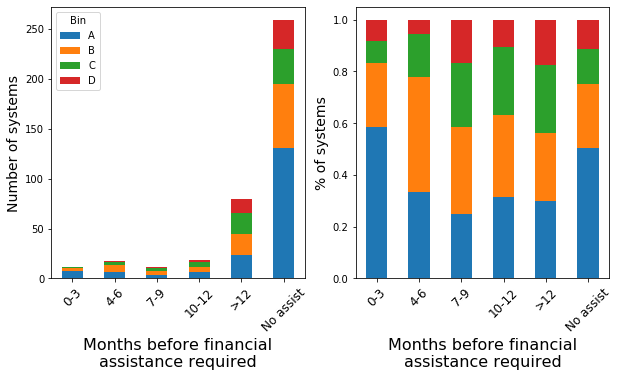

In [13]:
labs=['A','B','C','D','E','F']
labs2=['0-3','4-6','7-9','10-12','>12','No assist']
fig,ax=plt.subplots(1,2,figsize=(10,5))
qg.plot(kind='bar',ax=ax[0],stacked=True)
ax[0].set_xticklabels(labs2,rotation=45,size=12)        
ax[0].set_xlabel('Months before financial\nassistance required',size=16)
ax[0].set_ylabel('Number of systems',size=14)

qg2.plot(kind='bar',ax=ax[1],stacked=True,legend=None)
ax[1].set_xticklabels(labs2,rotation=45,size=12)        
ax[1].set_xlabel('Months before financial\nassistance required',size=16)
ax[1].set_ylabel('% of systems',size=14)

In [8]:
#Question 2: How many systems have deficits equivalent to x% of reserve funds?
dat=sq[['PWSID','sys_name','expense_2020_Total','revenue_2020_Total','cash_reserve_restricted','cash_reserve_unrestricted','cash_reserve_total','Population','Service Connections']]
dat.loc[:,'budget_diff']=dat['revenue_2020_Total']-dat['expense_2020_Total']
q2_store=pd.DataFrame()
for i,r in dat.iterrows():
    p=r['PWSID']
    res=r['budget_diff']
    cash=r['cash_reserve_total']
    cash_u=r['cash_reserve_unrestricted']
    if (np.isnan(cash_u)&(np.isnan(r['cash_reserve_restricted']))):
        cash_u=cash
    if len(p)>9:
        results=p.split(',')
        res2=[x.strip() for x in results]
        #look up the number of connections
        conns=conn_ref[conn_ref['PWSID'].isin(res2)]
    else:
        conns=conn_ref[conn_ref['PWSID']==p]
    conns.loc[:,'resp']=res
    conns.loc[:,'cash']=cash
    conns.loc[:,'cash_u']=cash_u
    q2_store=q2_store.append(conns,ignore_index=True)
q2_store=q2_store.drop_duplicates()
q22=q2_store.dropna(subset=['resp'])
q2def=q22[(q22['resp']<0)&(q22['cash']>0)].dropna(subset=['cash'])
q2def.loc[:,'cash_u']=q2def['cash_u']+1
q2def.loc[:,'ratio']=q2def['resp']/q2def['cash']
q2def.loc[:,'ratio_u']=q2def['resp']/q2def['cash_u']
ratio_labels=['Over 100% of reserve','75-100% of reserve','50-75% of reserve','25-50% of reserve','Less than 25% of reserve']

q2def.loc[:,'cash label']=pd.cut(q2def['ratio'],bins=[-100,-1,-0.75,-0.5,-0.25,0],
                               labels=ratio_labels)
q2def.loc[:,'cash_u label']=pd.cut(q2def['ratio_u'],bins=[-100,-1,-0.75,-0.5,-0.25,0],
                               labels=ratio_labels)
r2=ratio_labels[::-1]
qg=q2def.groupby(['cash label','Bin']).size().unstack().iloc[:,:-1].reindex(r2)
qg2=qg.copy()
ntot=qg2.sum(axis=1)
for c in qg2.columns:
    qg2.loc[:,c]=qg2[c]/ntot

C:\Anaconda-3.7\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Anaconda-3.7\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [9]:
qg3=q2def.groupby(['cash_u label','Bin']).size().unstack().iloc[:,:-1].reindex(r2)
print(qg)
print(qg3)

Bin                        A   B   C  D
cash label                             
Less than 25% of reserve  27  19  11  8
25-50% of reserve          4   2   2  0
50-75% of reserve          2   0   0  0
75-100% of reserve         2   0   1  1
Over 100% of reserve       4   2   4  0
Bin                        A   B   C  D
cash_u label                           
Less than 25% of reserve  24  17  11  6
25-50% of reserve          4   3   2  2
50-75% of reserve          2   1   0  0
75-100% of reserve         2   0   1  0
Over 100% of reserve       4   1   3  0


Text(0, 0.5, '% of systems')

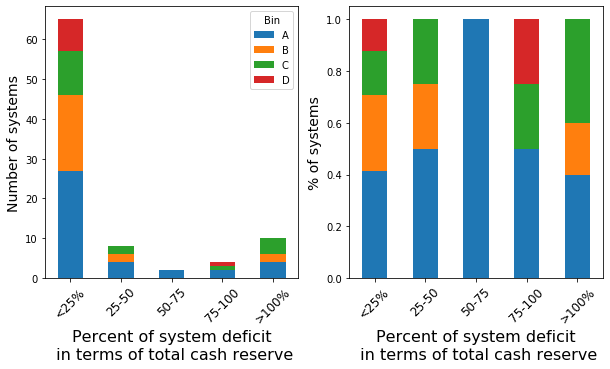

In [10]:
labs=['<25%','25-50','50-75','75-100','>100%']
fig,ax=plt.subplots(1,2,figsize=(10,5))
qg.plot(kind='bar',ax=ax[0],stacked=True)
ax[0].set_xticklabels(labs,rotation=45,size=12)        
ax[0].set_xlabel('Percent of system deficit\n in terms of total cash reserve',size=16)
ax[0].set_ylabel('Number of systems',size=14)

qg2.plot(kind='bar',ax=ax[1],stacked=True,legend=None)
ax[1].set_xticklabels(labs,rotation=45,size=12)        
ax[1].set_xlabel('Percent of system deficit\n in terms of total cash reserve',size=16)
ax[1].set_ylabel('% of systems',size=14)

In [11]:
#Question 5: What is the population served by systems with various levels of financial vulnerability?
#Days of cash on hand? Operating Ratio? Per capita revenue?

#number of days: April through October
ndays=30+31+30+31+31+30+31
dat=sq[['PWSID','sys_name','months_before_assist','expense_2020_Total','revenue_2020_Total','cash_reserve_restricted','cash_reserve_unrestricted','cash_reserve_total','Population','Service Connections']]

q5_store=pd.DataFrame()
for i,r in dat.iterrows():
    p=r['PWSID']
    cash=r['cash_reserve_total']
    cash_u=r['cash_reserve_unrestricted']
    expense=r['expense_2020_Total']
    rev=r['revenue_2020_Total']
    res=r['months_before_assist']
    
    if (np.isnan(cash_u)&(np.isnan(r['cash_reserve_restricted']))):
        #print(cash,r['cash_reserve_restricted'],cash_u)
        cash_u=cash
        #print(cash_u)

    if len(p)>9:
        results=p.split(',')
        res2=[x.strip() for x in results]
        #look up the number of connections
        conns=conn_ref[conn_ref['PWSID'].isin(res2)]
    else:
        conns=conn_ref[conn_ref['PWSID']==p]

    conns.loc[:,'cash']=cash
    conns.loc[:,'cash_u']=cash_u
    conns.loc[:,'cash_u_days']=cash_u/(expense/ndays)
    conns.loc[:,'cash_days']=cash/(expense/ndays)
    conns.loc[:,'op_ratio']=rev/expense
    conns.loc[:,'months']=res
    q5_store=q5_store.append(conns,ignore_index=True)
q5_store=q5_store.drop_duplicates()





C:\Anaconda-3.7\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Anaconda-3.7\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [12]:
#Assign risk scores based on various factors
#5: Extreme
#4: High
#3: Medium-high
#2: Medium
#1: low
#0: None
month_risk={'A':5,'B':4,'C':3,'D':2,'E':1,'F':0}
#only work with the ones that provide all info
q5_data=q5_store
q5_data.loc[:,'cash_score']=pd.cut(q5_data['cash_u_days'],bins=[-1,30,60,90,180,365,1000000000],labels=[5,4,3,2,1,0])
q5_data.loc[:,'ratio_score']=pd.cut(q5_data['op_ratio'],bins=[0,0.5,0.95,1.2,1.5,2,100],labels=[5,4,3,2,1,0])
q5_data.loc[:,'month_score']=q5_data['months'].map(month_risk)
q5_data.loc[:,'score_avg']=q5_data[['ratio_score','cash_score','month_score']].mean(axis=1)
#q5_data['score_avg'].hist()
q5_data.loc[:,'Risk label']=pd.cut(q5_data['score_avg'],bins=[-1,0.25,1.5,2.5,3.5,4.5,5.5],labels=['very low','low','medium','medium high','high','extreme'])

Text(0, 0.5, '% of systems')

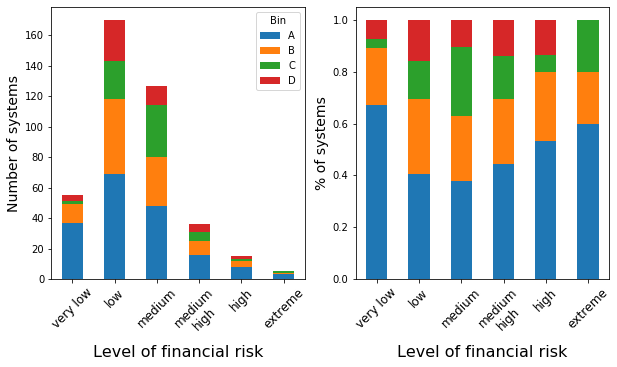

In [13]:
#q5_data.dropna(subset=['score_avg']).to_excel('risk_scores.xlsx',index=False)
q5_plot=q5_data.dropna(subset=['score_avg']).groupby(['Risk label','Bin']).size().unstack().iloc[:,:-1]
qtot=q5_plot.sum(axis=1)
q5_norm=q5_plot.copy()
for c in q5_norm.columns:
    q5_norm.loc[:,c]=q5_norm[c]/qtot

fig,ax=plt.subplots(1,2,figsize=(10,5))
q5_plot.plot(kind='bar',ax=ax[0],stacked=True)
ax[0].set_xticklabels(['very low','low','medium','medium\nhigh','high','extreme'],rotation=45,size=12)        
ax[0].set_xlabel('Level of financial risk',size=16)
ax[0].set_ylabel('Number of systems',size=14)

q5_norm.plot(kind='bar',ax=ax[1],stacked=True,legend=None)
ax[1].set_xticklabels(['very low','low','medium','medium\nhigh','high','extreme'],rotation=45,size=12)        
ax[1].set_xlabel('Level of financial risk',size=16)
ax[1].set_ylabel('% of systems',size=14)

In [14]:
#Statewide estimates with weights and imputed results
imp_data=pd.read_csv('../Datasets/smallSurvey_full_IMPUTED.csv',encoding = "ISO-8859-1")
own_data=pd.read_excel('../Datasets/ownership_reference.xlsx')

join_data=pd.merge(imp_data,own_data,how='left')
ndays=30+31+30+31+31+30+31
#months before assistance
month_v='months_before_assist.imputed'
# Cash reserve risk score
unr_c='cash_reserve_unrestricted.imputed'
#rev/expense ratio
rev_v='revenue_2020_Total.imputed'
exp_v='expense_2020_Total.imputed'
risk_data=imp_data[['tag','PWSID',rev_v,'revenue_2020_Total',exp_v,'expense_2020_Total',unr_c,'cash_reserve_unrestricted',month_v,'final.weight']]
risk_data.loc[:,'op_ratio']=risk_data[rev_v]/risk_data[exp_v]
risk_data.loc[:,'cash_u_days']=risk_data[unr_c]/(risk_data[exp_v]/ndays)
#Calculating the month risk score
def month_risk(row):
    if (row[month_v]=='A'):
        return(5) #High
    elif(row[month_v]=='B'):
        return(4) # High
    elif(row[month_v]=='C'):
        return(3) #Med
    elif(row[month_v]=='D'):
        return(2) # Med
    elif(row[month_v]=='E'):
        return(1) # Low
    elif(row[month_v]=='F'):
        return(0) # Low
risk_data.loc[:,'month_score']=risk_data.apply(month_risk,axis=1)
risk_data.loc[:,'ratio_score']=pd.to_numeric(pd.cut(risk_data['op_ratio'],bins=[0,0.5,0.95,1.2,1.5,2,1000000000],labels=[5,4,3,2,1,0]))
risk_data.loc[:,'cash_score']=pd.to_numeric(pd.cut(risk_data['cash_u_days'],bins=[-100,30,60,90,180,365,1000000000],labels=[5,4,3,2,1,0]))  


# for i,r in risk_data.iterrows():
#     risk_count=0
#     adj_count=0
#     new_score=0
#     if (r['month_score']>=4):
#         risk_count+=1
#         adj_count+=1
#     if ((r['month_score']>=2) & (r['month_score']<=3)):
#         adj_count+=0.25
#     if (r['ratio_score']>=4):
#         risk_count+=1
#         adj_count+=1
#     if ((r['ratio_score']>=2) & (r['ratio_score']<=3)):
#         adj_count+=0.25
#     if (r['cash_score']>=4):
#         risk_count+=1
#         adj_count+=1
#     if ((r['cash_score']>=2) & (r['cash_score']<=3)):
#         adj_count+=0.25
#     if (np.isnan(r['cash_score'])):
#         risk_count=-1
#         adj_count=-1
#     new_score+=r['month_score']/5
#     new_score+=r['ratio_score']/5
#     new_score+=r['cash_score']/5
    
#     risk_data.loc[i,'VScore']=risk_count
#     risk_data.loc[i,'AScore']=adj_count
#     risk_data.loc[i,'NScore']=new_score
# # #Testing the weighting



# summ_frame=pd.DataFrame()
# x=0
# for c in ['cash_score','ratio_score','month_score']:
#     dsub=risk_data[['tag','final.weight',c]].fillna(-1)
#     surv_resp=dsub.groupby(['tag',c]).size().unstack()
#     state_resp=dsub.groupby(['tag',c]).sum().unstack()['final.weight']
#     for t in surv_resp.index:
#         for i in surv_resp.columns:
#             summ_frame.loc[x,'Var']=c
#             summ_frame.loc[x,'Bin']=t
#             summ_frame.loc[x,'Val']=i
#             summ_frame.loc[x,'N']=surv_resp.loc[t,i]
#             summ_frame.loc[x,'N_W']=state_resp.loc[t,i]
#             x+=1
            
# summ_final=pd.DataFrame()
# x=0
# for c in ['VScore']:
#     dsub=risk_data[['tag','final.weight',c]].fillna(-1)
#     surv_resp=dsub.groupby(['tag',c]).size().unstack()
#     state_resp=dsub.groupby(['tag',c]).sum().unstack()['final.weight']
#     for t in surv_resp.index:
#         for i in surv_resp.columns:
#             summ_final.loc[x,'Var']=c
#             summ_final.loc[x,'Bin']=t
#             summ_final.loc[x,'Val']=i
#             summ_final.loc[x,'N']=surv_resp.loc[t,i]
#             summ_final.loc[x,'N_W']=state_resp.loc[t,i]
#             x+=1

C:\Anaconda-3.7\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Anaconda-3.7\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [9]:
risk_named=pd.merge(risk_data,name_ref,how='left')
risk_named.to_excel('vulnerability_scores_update.xlsx',index=False)

In [129]:
summ_frame.pivot_table(index=['Var','Bin'],columns='Val',values=['N','N_W']).to_clipboard()
#summ_final.pivot_table(index=['Var','Bin'],columns='Val',values=['N','N_W']).to_clipboard()

[Text(0, 0, 'low'),
 Text(0, 0, 'medium'),
 Text(0, 0, 'high'),
 Text(0, 0, 'extreme')]

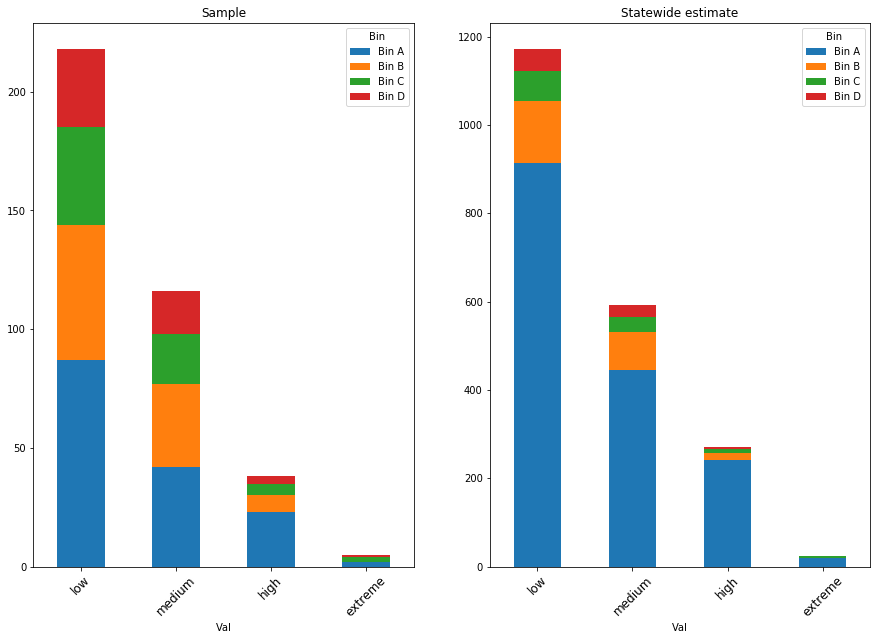

In [134]:
df_pivot=summ_final.pivot_table(index=['Var','Bin'],columns='Val',values=['N','N_W'])
fig,ax=plt.subplots(1,2,figsize=(15,10))
df_pivot.loc['VScore','N'][[0,1,2,3]].transpose().plot(kind='bar',stacked=True,ax=ax[0])
df_pivot.loc['VScore','N_W'][[0,1,2,3]].transpose().plot(kind='bar',stacked=True,ax=ax[1])
ax[0].set_title('Sample')
ax[1].set_title('Statewide estimate')
ax[0].set_xticklabels(['low','medium','high','extreme'],rotation=45,size=12) 
ax[1].set_xticklabels(['low','medium','high','extreme'],rotation=45,size=12) 

In [36]:
#Summary Stats for larges and smalls, using imputed data
imp_large=pd.read_csv('../Datasets/largesSurvey_full_IMPUTED.csv',encoding = "ISO-8859-1")
#large systems, totals
print(imp_large['dollars_del_dw_TotR.imputed'].sum()/1000000)
print(imp_large['dollars_del_acc_TotR.imputed'].sum()/1000000)
#zip data, number of accounts with >$1000 debt
zips[zips['Size'].str.contains('Small')]['More than $1000'].sum()
zips[zips['Size'].str.contains('Large')]['More than $1000'].sum()
zips['More than $1000'].sum()

195.17561971750152
671.7909386099991


155093.8

In [115]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from matplotlib.lines import Line2D

shape_dir=r'C:\Users\mpinheiro\Jupyter Notebooks\COVID-19\Visualizations\cb_2018_us_zcta510_500k'
county_dir=r'C:\Users\mpinheiro\Jupyter Notebooks\COVID-19\Visualizations\cb_2018_us_county_500k'
reader = shpreader.Reader('{:}/cb_2018_us_zcta510_500k.shp'.format(shape_dir))
zlist=list(reader.records())
creader = shpreader.Reader('{:}/cb_2018_us_county_500k.shp'.format(county_dir))
clist = list(creader.records())

In [122]:
#California counties only 
c_shapes=[]
for c in clist:
    cname=c.attributes['STATEFP']
    if cname=='06':
        c_shapes+=[c.geometry]
COUNTIES=cfeature.ShapelyFeature(c_shapes,ccrs.PlateCarree())        

In [162]:
zip_nums=zips[['Zip Code','Total number of delinquent residential accounts','More than $1000']].groupby('Zip Code').sum()
ztot=zip_nums.sort_values('Total number of delinquent residential accounts',ascending=False).head(10)
totlist=['{:}'.format(z) for z in list(ztot.index)]
tot_shapes=[]
for z in zlist:
    zname=z.attributes['ZCTA5CE10']
    if zname in totlist:
        tot_shapes+=[z.geometry]
TZIPS=cfeature.ShapelyFeature(tot_shapes,ccrs.PlateCarree())

z1000=zip_nums.sort_values('More than $1000',ascending=False).head(11)
z1000=z1000.tail(10)
list1000=['{:}'.format(z) for z in list(z1000.index)]
shapes_1000=[]
for z in zlist:
    zname=z.attributes['ZCTA5CE10']
    if zname in list1000:
        shapes_1000+=[z.geometry]
ZIPS1000=cfeature.ShapelyFeature(shapes_1000,ccrs.PlateCarree())

{'ZCTA5CE10': '90001', 'AFFGEOID10': '8600000US90001', 'GEOID10': '90001', 'ALAND10': 9071081, 'AWATER10': 0}
{'ZCTA5CE10': '90044', 'AFFGEOID10': '8600000US90044', 'GEOID10': '90044', 'ALAND10': 13303665, 'AWATER10': 0}
{'ZCTA5CE10': '90201', 'AFFGEOID10': '8600000US90201', 'GEOID10': '90201', 'ALAND10': 15377705, 'AWATER10': 294863}
{'ZCTA5CE10': '90011', 'AFFGEOID10': '8600000US90011', 'GEOID10': '90011', 'ALAND10': 11100438, 'AWATER10': 515}
{'ZCTA5CE10': '90650', 'AFFGEOID10': '8600000US90650', 'GEOID10': '90650', 'ALAND10': 25408338, 'AWATER10': 101801}
{'ZCTA5CE10': '90003', 'AFFGEOID10': '8600000US90003', 'GEOID10': '90003', 'ALAND10': 9197637, 'AWATER10': 403}
{'ZCTA5CE10': '92324', 'AFFGEOID10': '8600000US92324', 'GEOID10': '92324', 'ALAND10': 76922869, 'AWATER10': 1323573}
{'ZCTA5CE10': '90630', 'AFFGEOID10': '8600000US90630', 'GEOID10': '90630', 'ALAND10': 15867875, 'AWATER10': 23872}
{'ZCTA5CE10': '95670', 'AFFGEOID10': '8600000US95670', 'GEOID10': '95670', 'ALAND10': 3270

In [251]:
zip_pc_tot=['94569','92397','95422','93455','92311','90028','90232','90001','90008','92378']
tp_shapes=[]
for z in zlist:
    zname=z.attributes['ZCTA5CE10']
    if zname in zip_pc_tot:
        tp_shapes+=[z.geometry]
TPZIPS=cfeature.ShapelyFeature(tp_shapes,ccrs.PlateCarree())

zip_pc_1000=['92341','93558','91307','91436','90003','91304','90047','91311','93528','91042']
t1_shapes=[]
for z in zlist:
    zname=z.attributes['ZCTA5CE10']
    if zname in zip_pc_1000:
        t1_shapes+=[z.geometry]
T1ZIPS=cfeature.ShapelyFeature(t1_shapes,ccrs.PlateCarree())

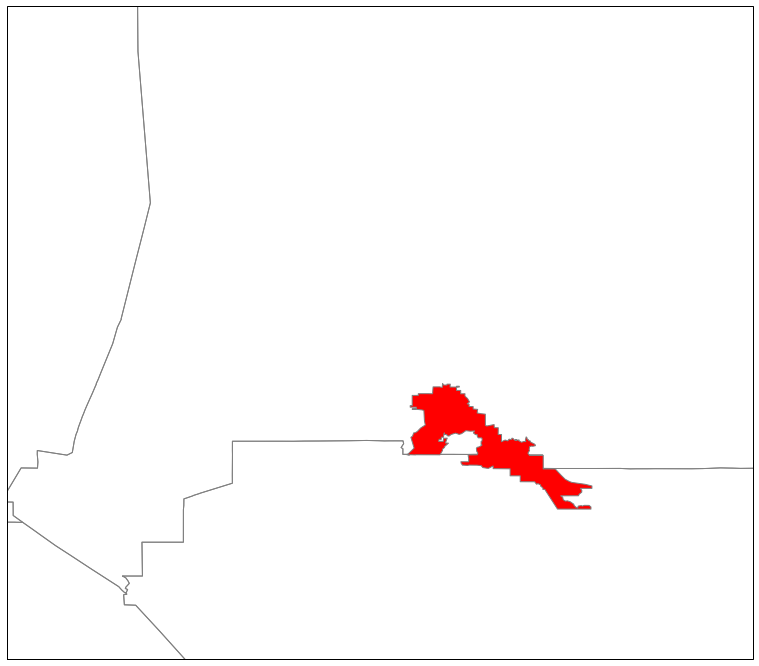

In [205]:
fig,ax=plt.subplots(figsize=(20,12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.STATES.with_scale('10m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))
#ax.add_feature(cfeature.LAKES.with_scale('50m'))
ax.add_feature(COUNTIES, facecolor='none', edgecolor='gray')

#Total number of households
ax.add_feature(TZIPS, facecolor='red', edgecolor='gray')
#Full extent
ax.set_extent([-124,-114.2,33,42])
#zooming in, SoCal
#ax.set_extent([-121,-117,33,35.5])
#zooming in, LA
#ax.set_extent([-118.5,-117.8,33.5,34.2])
#Zooming in, norcal
ax.set_extent([-122,-121,38,39])
#zooming in, orcutt
#ax.set_extent([-121,-120,34.4,35.3])
#zooming in, colton
ax.set_extent([-117.8,-117,33.8,34.5])

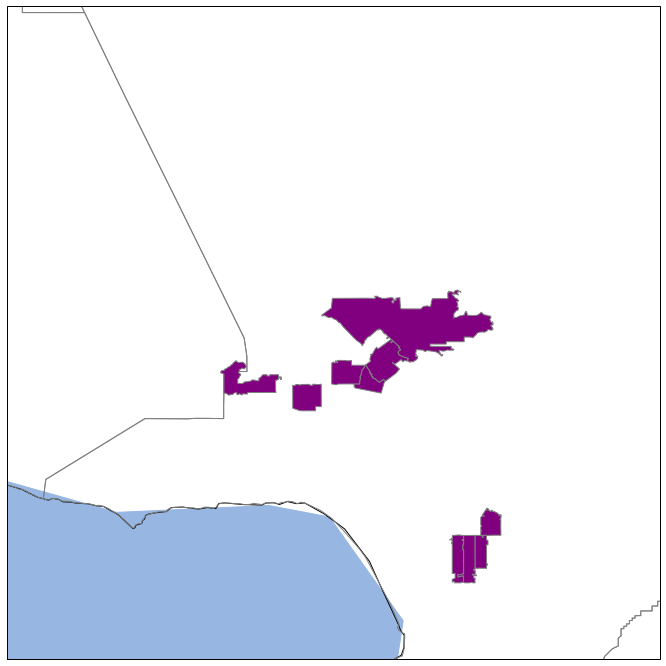

In [204]:
#Number of $1000 accounts
fig,ax=plt.subplots(figsize=(20,12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.STATES.with_scale('10m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))
#ax.add_feature(cfeature.LAKES.with_scale('50m'))
ax.add_feature(COUNTIES, facecolor='none', edgecolor='gray')

#Total number of households
ax.add_feature(ZIPS1000, facecolor='purple', edgecolor='gray')
#Full extent
ax.set_extent([-124,-114,33,42])
#zooming in, SoCal
ax.set_extent([-119,-118,33.8,34.8])


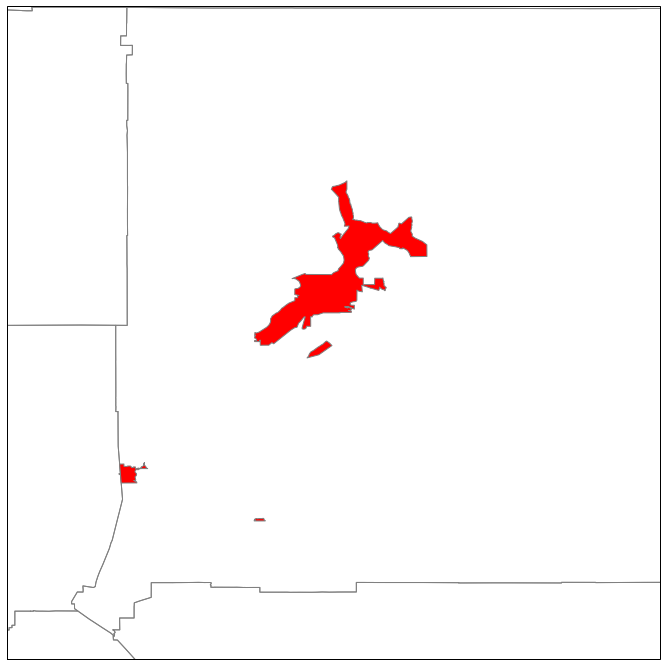

In [250]:
fig,ax=plt.subplots(figsize=(20,12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.STATES.with_scale('10m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))
#ax.add_feature(cfeature.LAKES.with_scale('50m'))
ax.add_feature(COUNTIES, facecolor='none', edgecolor='gray')

#Total number of households
ax.add_feature(TPZIPS, facecolor='red', edgecolor='gray')
#Full extent
ax.set_extent([-124,-114,33,42])
#zooming in, SoCal
#ax.set_extent([-119,-118,33.8,34.8])
#Zooming in, NorCal
#ax.set_extent([-123.5,-121.5,37.5,39.2])
#Zooming in, LA
#ax.set_extent([-118.5,-117.8,33.5,34.2])
#Zooming in, San Bernardino
ax.set_extent([-118,-116,33.8,35.8])

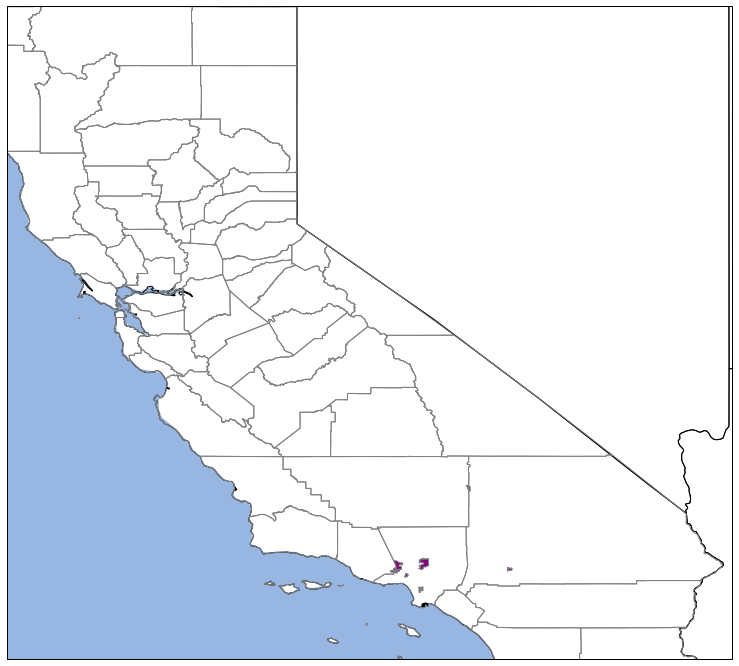

In [257]:
#per capita $1000 accounts

fig,ax=plt.subplots(figsize=(20,12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.STATES.with_scale('10m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))
#ax.add_feature(cfeature.LAKES.with_scale('50m'))
ax.add_feature(COUNTIES, facecolor='none', edgecolor='gray')

#Total number of households
ax.add_feature(T1ZIPS, facecolor='purple', edgecolor='gray')
#Full extent
ax.set_extent([-124,-114,33,42])
#zooming in, SoCal
#ax.set_extent([-119,-116,33.8,36])
